In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.ticker as mtick
from scipy.spatial import distance_matrix
from fc_nets import *
from utils import *

sns.set(font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{dsfont}'



from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import warnings
warnings.filterwarnings('ignore')
# colors = ['blue', 'orange', 'olive', 'brown', 'cornflowerblue', 'red', 'k', 'purple']
colors = ['lightsteelblue', 'cornflowerblue', 'blue', 'midnightblue', 'black']
label_size = 16
hps = {
    'basic': {'n': 50, 'd': 5, 'm_teacher': [2, 2], 'm_student': [10, 10], 'init_scales_teacher': [1.0, 1.0, 1.0], 'init_scales_student': [0.8, 0.8, 0.8], 'seed': 5, 'gamma': 0.05, 'warmup_mult_factor': 3.0},  # very good
}

y: tensor([-0.6163,  0.9799,  0.3886,  0.1911,  0.3208, -0.6920, -0.3344, -0.1105,
         1.2851, -0.3311, -0.3538,  0.1733,  0.4452, -0.3344, -0.7375,  1.0582,
         1.5013,  1.5295, -0.3344, -0.6533, -0.5735, -0.2546, -0.3344, -0.6990,
        -0.3488, -0.2804, -0.3344,  0.2483,  1.6744,  0.7830, -0.6063, -0.7993,
         1.2405,  0.8937, -0.7313,  1.4646, -0.6014,  0.1429, -0.8252,  1.1880,
         0.7283, -0.3344, -0.6031, -0.4499, -0.2467,  0.5621,  0.1708, -0.3344,
        -0.3344,  1.6238])
batch_size=1, gamma=0.011: train loss 0.0013713681837543845, test loss 0.061387766152620316, eff_rank 2.0017507076263428, activation_frac_nonzero_layer1 57.0, activation_frac_nonzero_layer2 46.6
batch_size=1, gamma=0.040: train loss 0.0010971605079248548, test loss 0.03218121454119682, eff_rank 2.033604621887207, activation_frac_nonzero_layer1 47.6, activation_frac_nonzero_layer2 31.2
batch_size=1, gamma=0.040: train loss 0.0010054792510345578, test loss 0.02477150969207287, eff_rank 1

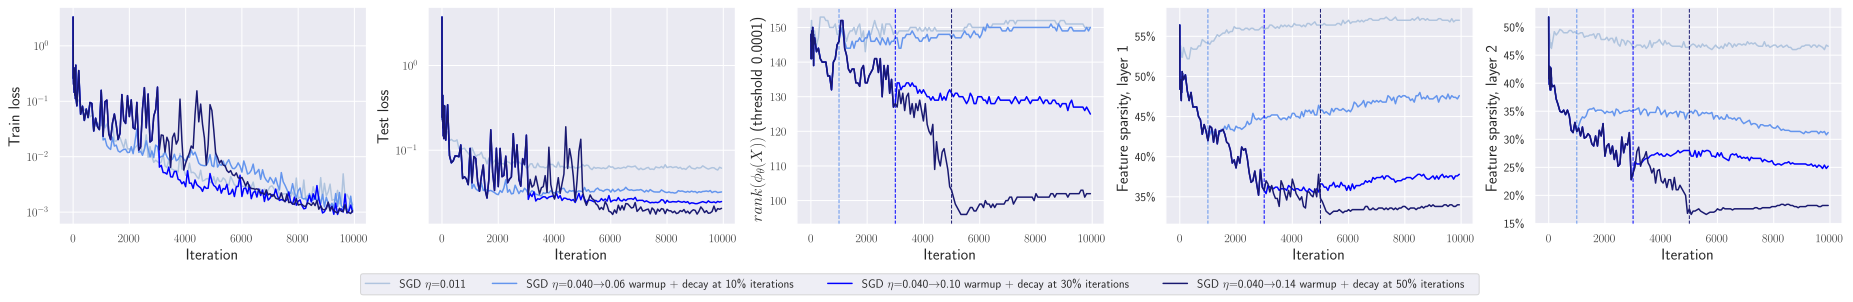

In [2]:
### final setting that we will report in the appendix
exp = 'basic' 
X, y, X_test, y_test, net_teacher = get_data_multi_layer_relu_net(hps[exp]['n'], hps[exp]['d'], hps[exp]['m_teacher'], hps[exp]['init_scales_teacher'], hps[exp]['seed'])
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.0, x_log_scale=x_log_scale)  #, n_iters_next=125)  # 4.15
lp = 0.1
l0_threshold = 0.5
weight_avg = 0.0
l0_threshold_grad_matrix = 0.0001
scale_features = False
n_plots = 5

nets_all = []
plt.figure(figsize = (32, 4))

warmup_mult_factor = 6.0  # hps[exp]['warmup_mult_factor']
gammas = [0.011, 0.04, 0.04, 0.04]
schedule_lengths = [0.0, 0.1, 0.3, 0.5]
decay_factors = [1.0, 3.5, 2.5, 5.0]
batch_sizes = [1] * len(schedule_lengths)
for i, (gamma, batch_size, schedule_length, decay_factor) in enumerate(zip(gammas, batch_sizes, schedule_lengths, decay_factors)):
    np.random.seed(hps[exp]['seed'])
    torch.manual_seed(hps[exp]['seed'])

    net_init = FCNet(n_feature=hps[exp]['d'], n_hidden=hps[exp]['m_student'], biases=True) 
    net_init.init_gaussian(init_scales=hps[exp]['init_scales_student'])
    train_losses, test_losses, nets = train_fc_net(X, y, X_test, y_test, gamma, batch_size, net_init, iters_loss, num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], iters_percentage_linear_warmup=schedule_length, gamma_warmup_factor_max=warmup_mult_factor, warmup_exponent=0.5) 
    nets_all.append(nets)
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X_test[:n_params]
    effective_rank_features = np.array([effective_rank(np.linalg.svd(net.features(X_eval, scaled=scale_features))[1]) for net in nets])
    activation_frac_nonzeros_layer1 = np.array([(F.relu(net.layers[0](X)).data.numpy() != 0).mean()*100 for net in nets])
    activation_frac_nonzeros_layer2 = np.array([(net.features(X) != 0).mean()*100 for net in nets])
    feature_sparsity_layer1 = np.array([net.feature_sparsity(X, n_hidden_to_take=1) for net in nets])
    feature_sparsity_layer2 = np.array([net.feature_sparsity(X, n_hidden_to_take=2) for net in nets])
    n_active_relus = np.array([((net.features(X) != 0.0).sum(0) != 0.0).sum() for net in nets])
    grad_matrix_ranks = compute_grad_matrix_ranks(nets, X_eval, l0_threshold_grad_matrix)
    print('batch_size={}, gamma={:.3f}: train loss {}, test loss {}, eff_rank {}, activation_frac_nonzero_layer1 {:.1f}, activation_frac_nonzero_layer2 {:.1f}'.format(batch_size, gamma, train_losses[-1], test_losses[-1], effective_rank_features[-1], activation_frac_nonzeros_layer1[-1], activation_frac_nonzeros_layer2[-1]))

    label = '{}'.format('SGD' if batch_size < hps[exp]['n'] else 'GD')
    if warmup_mult_factor == 1.0 or schedule_length == 0.0:
        label += ' $\eta$={:.3f}'.format(gamma)
    else:
        label += ' $\eta$={:.3f}$\\rightarrow${:.2f} warmup'.format(gamma, gamma + (warmup_mult_factor - 1)*gamma*schedule_length)
    if schedule_length > 0:
        label += ' + decay at ' + str(int(schedule_length*100)) + r'\% iterations'

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(bottom=10**-5, top=10**-0.5)
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss, test_losses, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, grad_matrix_ranks, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$rank(\phi_\\theta(X))$ (threshold {})'.format(l0_threshold_grad_matrix), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, 100*feature_sparsity_layer1, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Feature sparsity, layer 1', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 5)
    plt.plot(iters_loss, 100*feature_sparsity_layer2, label=label, color=colors[i], linestyle='solid' if weight_avg==0 else '--')
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Feature sparsity, layer 2', fontsize=label_size)


plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.2), ncol=7)
plt.savefig("plots/fc_net_multi_layer_exp={}_lp={}.pdf".format(exp, lp), bbox_inches='tight')
plt.show()